## Naive Experiment part 2 (Adversarial)

In [ ]:
import torch
import torchvision


from IPython.display import clear_output
import time
import tqdm
from tqdm import tqdm_notebook
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

As soon as we trained 11 models of CNN to classify images of CIFAR10 and obtained SKD for each layer of the CNN, one can move on the following part of the experiment. Namely, adversarial training for CNN with discriminators for each layer.

In [ ]:
torch.cuda.is_available()

True

Download data from CIFAR 100 to train our network CNN

In [ ]:
train_val_dataset = torchvision.datasets.CIFAR100(root='./data',train=True,transform=torchvision.transforms.ToTensor(),download=True)
test_dataset = torchvision.datasets.CIFAR100(root='./data',train=False, transform=torchvision.transforms.ToTensor(),download=True)
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [40000,10000])

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Let me define the neural network for training on CIFAR100


1.   1 layer: 128*3 7x7 filters
2.   2 layer: 128*256 5x5 filters
3.   3 layer: 256*256 5x5 filters



In [ ]:
class SimpleConvNet(torch.nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv1 = torch.nn.Conv2d(in_channels = 3,out_channels = 128, kernel_size = 7,stride = 1) 
    self.relu1 = torch.nn.LeakyReLU()
    self.mp1 = torch.nn.MaxPool2d(kernel_size = 2,stride = 2,padding = 0,dilation=1,ceil_mode=False)
    self.bn1 = torch.nn.BatchNorm2d(128)
    self.droupout1 = torch.nn.Dropout(0.3)
    # [batch,128, 13 , 13]
        
    self.conv2 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5,stride=1)
    self.bn2 = torch.nn.BatchNorm2d(256)
    self.droupout2 = torch.nn.Dropout(0.3)
    self.relu2 = torch.nn.LeakyReLU()
    #[batch,256,9,9]

    self.conv3 = torch.nn.Conv2d(in_channels=256,out_channels=256,kernel_size=5,stride=1)
    self.bn3 = torch.nn.BatchNorm2d(256)
    self.dropout3 = torch.nn.Dropout(0.3)
    self.relu3 = torch.nn.LeakyReLU()
    #[batch,256,5,5]
        
    self.flatten = torch.nn.Flatten()
    self.fc4 = torch.nn.Linear(256*5*5, 512)
    self.droupout4 = torch.nn.Dropout(0.3)
    self.relu4 = torch.nn.ReLU()
    self.fc5 = torch.nn.Linear(512, 100)

  def forward(self, x):
    layer1 = self.mp1(self.relu1(self.conv1(x)))
    layer1 = self.droupout1(self.bn1(layer1))
        
    layer2 = self.conv2(layer1)
    layer2 = self.relu2(self.droupout2(self.bn2(layer2)))

    layer3 = self.conv3(layer2)
    layer3 = self.relu3(self.dropout3(self.bn3(layer3)))
        
    out = self.flatten(layer3)
    out = self.relu4(self.droupout4(self.fc4(out)))
    out = self.fc5(out)
    return out # [batch,100] i.e. batch of logits

Now one can define Discriminator for each layer of our convolutional neural network.

In [ ]:
class Discriminator(torch.nn.Module):
  def __init__(self, input_dim, hidden, output_dim):
    super().__init__()

    assert isinstance(hidden, list)
    self.hidden = hidden
    self.input_dim = input_dim
    self.output_dim = output_dim

    model = list()
    hidden_layers = [input_dim] + hidden + [output_dim]
    for hidden_curr , hidden_next in zip(hidden_layers,hidden_layers[1:]):
      model.extend([torch.nn.Linear(in_features= hidden_curr,out_features= hidden_next),
                    torch.nn.LeakyReLU()])
    model.pop() # to remove final LeakyReLU
    self.net = torch.nn.Sequential(*model)

  
  def forward(self,input):
    batch_size = input.shape[0]
    input = input.view(input.shape[0],input.shape[-1]*input.shape[-1])
    answer = self.net(input)
    return torch.sigmoid(answer)

In [ ]:
HIDDEN_DISCR = [100,100]
output_dim = 1 # since there is a probability


model = SimpleConvNet().cuda()
discriminator_layer_1 = Discriminator(7*7,HIDDEN_DISCR,output_dim).cuda() # 7X7
discriminator_layer_2 = Discriminator(5*5,HIDDEN_DISCR,output_dim).cuda() # 5X5
discriminator_layer_3 = Discriminator(5*5,HIDDEN_DISCR,output_dim).cuda() # 5X5
discriminator_vocabulary = {'conv1':discriminator_layer_1,\
                          'conv2':discriminator_layer_2,\
                          'conv3':discriminator_layer_3}

In [ ]:
LR = 1e-3
optimizer_generator = torch.optim.Adam(model.parameters(),lr = LR )
optimizer_discriminator_layer_1 = torch.optim.Adam(discriminator_layer_1.parameters(),lr= LR )
optimizer_discriminator_layer_2 = torch.optim.Adam(discriminator_layer_2.parameters(),lr= LR )
optimizer_discriminator_layer_3 = torch.optim.Adam(discriminator_layer_3.parameters(),lr= LR)

In [ ]:
# n - names of variables in SimpleConvNet()
# m - neural network or activation function (like self.n = m)
convolutional_weights_CNN = {n: m.weight for n,m in model.named_modules() if isinstance(m, torch.nn.Conv2d)}
# dict.keys() : 'conv1' , 'conv2', 'conv3'
# dict['conv1'].shape = torch.Size([128,3,7,7])
# dict['conv2'].shape = torch.Size([256,128,5,5])
# dict['conv3'].shape = torch.Size([256,256,5,5])

Thus, we have created convolutional neural network and discriminator for each of 3 layers , its optimizers and the dictionary of each convolutional layer.

#### SKD

In [ ]:
import os
import pickle

path = os.path.join('drive', 'My Drive','filters', 'Filters_1_layer_3.pkl')
with open(path, 'rb') as handle:
    tensor = pickle.load(handle)

In [ ]:
#conv1_tensor_ = torch.cat([tensor_,tensor])
#conv2_tensor_ = torch.cat([tensor_,tensor])
conv3_tensor_= torch.cat([tensor_,tensor])

In [ ]:
filters_1 = conv1_tensor_.reshape(8*128*3,7,7)
filters_2 = conv2_tensor_.reshape(8*256*128,5,5)
filters_3 = conv3_tensor_.reshape(8*256*256,5,5)

norms_1 = torch.linalg.norm(filters_1,dim=(-2,-1))
norms_2 = torch.linalg.norm(filters_2,dim=(-2,-1))
norms_3 = torch.linalg.norm(filters_3,dim=(-2,-1))
norms = list()
norms.extend([norms_1,norms_2,norms_3])

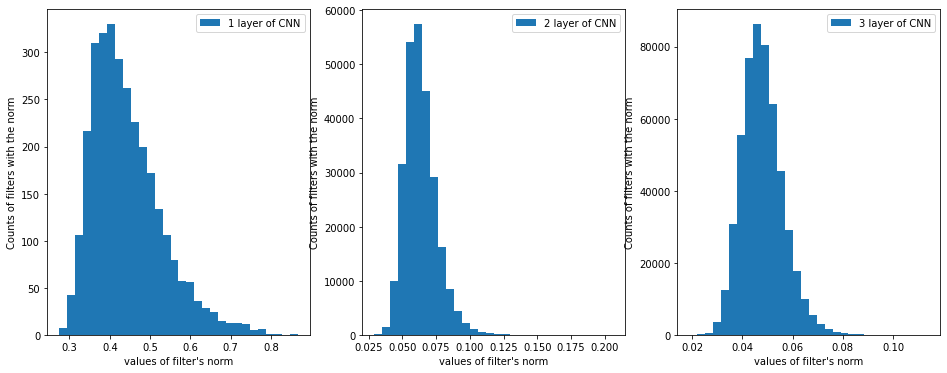

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(16,6))
ax = ax.flatten()
for idx in range(3):
  ax[idx].hist(norms[idx], density=False, bins=30,label= str(idx + 1) + " layer of CNN") 
  ax[idx].set_ylabel('Counts of filters with the norm')
  ax[idx].set_xlabel("values of filter's norm")
  ax[idx].legend()
plt.show();

In [ ]:
SKD_convolutional_weights = {n: filters for n,filters in zip( ['layer_1','layer_2','layer_3'],\
                                                             [filters_1,filters_2,filters_3])}
# SKD_convolutional_weigths['layer_1'] = torch.Size([3072,7,7])
# SKD_convolutional_weigths['layer_2'] = torch.Size([262144,5,5])
# SKD_convolutional_weigths['layer_3'] = torch.Size([524288,7,7])

Thus, we have :


1.   CNN 
2.   dictionary of filters for each layer of the CNN
3.   Discriminator for each layer 
4.   dictionary of SKD filters for each layer



 ### Discriminator training

It is worth noticing, that training of the discriminator will happen when generator(CNN and its filters) is fixed. Thus, the only parameter is trained during the training of this training - it is parameters of discriminator network $\theta$. Then, one can consider loss of a discriminator that delas with the $j$ - th layer.
$$ Loss(\theta_{j}) = -(\mathbb{E}_{w_{j}}[\log(1 - \mathbb{D}_{j}(w,\theta_{j}))] + \mathbb{E}_{w_{skd_{j}}} [\log \mathbb{D}_{j}(w,\theta_{j})])  \to \min_{\theta_{j}}$$

1. First of all, one has to create train_loader that is based on SKD filters of each layer

In [ ]:
BATCH_1 = 20
BATCH_2 = 300
BATCH_3 = 500
train_loader_1 = torch.utils.data.DataLoader(dataset=SKD_convolutional_weights['layer_1'],batch_size=BATCH_1,shuffle=False)
train_loader_2 = torch.utils.data.DataLoader(dataset=SKD_convolutional_weights['layer_2'],batch_size=BATCH_2,shuffle=False)
train_loader_3 = torch.utils.data.DataLoader(dataset=SKD_convolutional_weights['layer_3'],batch_size = BATCH_3, shuffle=False )

In [ ]:
SKD_convolutional_weights['layer_3'].shape

torch.Size([524288, 5, 5])

The following class is able to sample random batch of fiteness filters of a layer.

In [ ]:
class fake_data_sampler:

  def __init__(self, tensor, batch_size):
    super().__init__()

    assert batch_size <= tensor.shape[0]

    self.tensor = tensor
    self.batch_size = batch_size

  def __iter__(self):
    return self

  def __next__(self, low, high):
    return self.tensor[low : high]

  def sample(self):
    low = np.random.randint(self.tensor.shape[0] - self.batch_size)
    high = low + self.batch_size
    return self.__next__(low,high) 

In [ ]:
def plot_gan_training(losses, title , num_epochs):
  n_itr = len(losses)
  xs = np.arange(n_itr)

  plt.figure(figsize=(7, 5))
  plt.plot(xs, losses, label = str(num_epochs) + " epochs")
  plt.title(title)
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
def discriminator_loss(discriminator,true_data,title):
  #true_data : SKD filter of j-th layer : torch.Size([batch,size,size])
   
  assert title in ['conv1','conv2','conv3']
  fake_data = convolutional_weights_CNN[title].reshape(convolutional_weights_CNN[title].shape[0]\
                                                           *convolutional_weights_CNN[title].shape[1],
                                                           true_data.shape[1],true_data.shape[2])
  #fake_data : fitness filters of j-th layer :torch.Size([batch,size,size])
  fake_sampler = fake_data_sampler(fake_data, true_data.shape[0])
  fake_data = fake_sampler.sample()

  return - torch.mean(torch.log(discriminator(true_data.cuda())) + torch.log(1 - discriminator(fake_data.cuda())))

In [ ]:
def make_step(loss_fn, discriminator,true_data,title, optimizer):
  loss = loss_fn(discriminator, true_data, title )
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

In [ ]:
def train_epoch_discriminator(
    discriminator,  # discriminator_layer_1 
    discr_loss_fn,  # discriminator_loss(discriminator_layer_1, batch of train loader 1, 'conv1')
    train_loader,  # train_loader_1 (SKD_{1})
    title,         # 'conv1'
    discr_optimizer, # optimizer_discriminator_layer_1
    discr_steps=1 #  ## picked out before ##
):
    discriminator.train()

    discr_losses = list()
    for true_data in train_loader:
        discr_loss = make_step(discr_loss_fn, discriminator,true_data, title, discr_optimizer)
        discr_losses.append(discr_loss.item())


    return {
        'discriminator_losses': discr_losses
    }

In [ ]:
def train_discriminator(
    discriminator, # discriminator_layer_1
    discr_loss_fn, # discriminator_loss(discriminator_layer_1, batch of train loader 1, 'conv1')
    train_loader, # train_loader_1 (SKD_{1})
    title, # 'conv1'
    epochs, # num_epochs : ## pick out ##
    discr_optimizer, # optimizer_discriminator_layer_1
    discr_steps=1 # discr_steps  ## pick out ##
):
    

    train_losses = {}

    for epoch in range(epochs):

        train_loss = train_epoch_discriminator(
            discriminator, 
            discr_loss_fn,
            train_loader,
            title, 
            discr_optimizer, 
            discr_steps=discr_steps
        )
        # return  train_loss = {'discriminator losses' : discr_losses}
        
        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
            train_losses[k].extend(train_loss[k])

    return train_losses

In [ ]:
# train
EPOCHS = 5
DISCR_STEPS = 1
train_losses = train_discriminator( 
    discriminator_layer_1,  
    discriminator_loss, 
    train_loader_1, 
    title = 'conv1',
    epochs=EPOCHS,
    discr_optimizer = optimizer_discriminator_layer_1,
    discr_steps=DISCR_STEPS
)

Right mow, one can check how discriminator is able to distinguish filters of the first layer of the CNN from filters of the first layer that deal with the  SKD

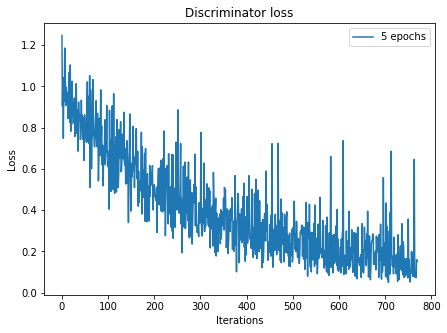

In [ ]:
plot_gan_training(train_losses['discriminator_losses'], 'Discriminator loss', EPOCHS)

### CNN with adversarial loss

CNN with adversarial loss should minimize loss of classifiaction as well as perplex (mislead) the discriminator at the same time. These points are reflected in the following expression:
$$ Loss(w) = \frac{1}{m}\sum_{i = 1} \mathcal{l}(y_{i}| x_{i},w) - \sum_{j}C_{j}\mathbb{E}_{w_{j}} \log D_{j}(w_{j},\theta_{j}) \to \min_{w} $$
$\theta_{j}$ is fixed 

In [ ]:
def plot_learning_curves(history):
    '''
     
    This function is aimed to show up at all loss and accuracy (metrics) during the training of the model

    :param history: (dict)
        accuracy and loss on the training and validation
    '''
    # sns.set_style(style='whitegrid')

    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Loss', fontsize=15)

    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='validation')

    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Num epochs', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Accuracy', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='validation')
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('Num epochs', fontsize=15)
    plt.legend()
    plt.show()

In [48]:
def train_CNN(num_epochs, ## pick out ##
                    model, # SimpleConvNet()
                    train_loader, # train_loader (CIFAR 100)
                    val_loader, # val_loader (CIFAR 100)
                    optimizer_model, # optimizer_generator
                    criterion, # torch.nn.CrossEntropyLoss()
                    batch_fake,
                    discr_steps, # by default 1
                    epochs_discr=1
                    ):
  
  history = defaultdict(lambda: defaultdict(list))

  for epoch in tqdm_notebook(range(num_epochs)):

    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    start_time = time.time()
    model.train(True)


    for batch_x,batch_y in tqdm_notebook(train_loader):
      batch_x,batch_y = torch.autograd.Variable(batch_x), torch.autograd.Variable(batch_y)
      batch_x,batch_y = batch_x.cuda(),batch_y.cuda()

      optimizer_generator.zero_grad()

      ###
      confusion = list()
      for name, wgt in convolutional_weights_CNN.items():
        # name : name of convolutional NN : ['conv1','conv2','conv3']
        # wgt:  convolutional filters : [torch.Size(128,3,7,7),torch.Size(256,128,5,5),torch.Size(256,256,5,5)]
        wgt = wgt.detach()
        wgt = wgt.reshape( wgt.shape[0]*wgt.shape[1] , wgt.shape[2], wgt.shape[3])
        fake_sampler = fake_data_sampler(wgt, batch_fake)
        fake_data = fake_sampler.sample().cuda()

        discriminator = discriminator_vocabulary[name]
        discriminator.eval()
        loss =  torch.mean((1 - discriminator(fake_data)).square()) #-  torch.mean(torch.log(discriminator(fake_data))  - torch.log( 1 - discriminator(fake_data)))
        confusion.append(loss)

      ###

      logits = model(batch_x)
      loss_task = criterion( logits ,batch_y.long().cuda())

      full_loss = loss_task * 1.0  +  sum(confusion)*0.01
      full_loss.backward()
      optimizer_generator.step()

      train_loss += np.sum(full_loss.detach().cpu().numpy())
      y_pred = logits.max(1)[1].detach().cpu().numpy()
      train_acc += np.mean(batch_y.cpu().numpy() == y_pred)

    # calculate loss and accuracy and  save to "историю"
    train_loss /= len(train_loader)
    train_acc /= len(train_loader) 
    history['loss']['train'].append(train_loss)
    history['acc']['train'].append(train_acc)
 
    ## discrimantors train  ##
    ## model does not train ##
    model.eval()
     
    train_losses_1 = train_discriminator( 
      discriminator_layer_1,  
      discriminator_loss, 
      train_loader_1, 
      title = 'conv1',
      epochs= epochs_discr,
      discr_optimizer = optimizer_discriminator_layer_1,
      discr_steps=DISCR_STEPS)
    

    train_losses_2 = train_discriminator( 
      discriminator_layer_2,  
      discriminator_loss, 
      train_loader_2, 
      title = 'conv2',
      epochs=epochs_discr,
      discr_optimizer = optimizer_discriminator_layer_2,
      discr_steps=DISCR_STEPS)
  
    train_losses_3 = train_discriminator( 
      discriminator_layer_3,  
      discriminator_loss, 
      train_loader_3, 
      title = 'conv3',
      epochs=epochs_discr,
      discr_optimizer = optimizer_discriminator_layer_3,
      discr_steps=DISCR_STEPS) 

    for batch_x,batch_y in tqdm_notebook(val_loader):
      batch_x,batch_y = torch.autograd.Variable(batch_x),torch.autograd.Variable(batch_y)
      batch_x,batch_y = batch_x.cuda(),batch_y.cuda()
      logits = model(batch_x)
      loss_val = criterion(logits, batch_y.long().cuda())
      val_loss += np.sum(loss_val.detach().cpu().numpy())
      y_pred = logits.max(1)[1].detach().cpu().numpy()
      val_acc += np.mean(batch_y.cpu().numpy() == y_pred)

    val_loss /= len(val_loader)
    val_acc /= len(val_loader) 
    history['loss']['val'].append(val_loss)
    history['acc']['val'].append(val_acc)

    clear_output()
        
    #print results after each epoch
    print("Epoch {} of {} took {:.3f}s".format(
              epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
    print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
    print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
    print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
    plot_learning_curves(history)
  return model,history
  

  







Epoch 18 of 50 took 30.805s
  training loss (in-iteration): 	0.285390
  validation loss (in-iteration): 	4.050400
  training accuracy: 			92.15 %
  validation accuracy: 			42.91 %


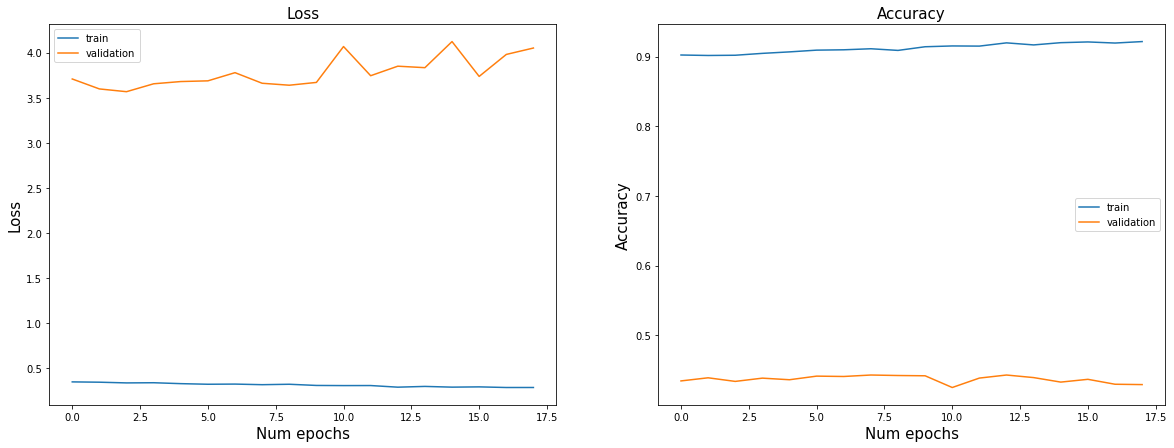

In [ ]:
DISCR_STEPS = 1
NUM_EPOCHS = 50
BATCH_FAKE = 30
modeler,history = train_CNN(NUM_EPOCHS, ## pick out ##
                    model, # SimpleConvNet()
                    train_loader, # train_loader (CIFAR 100)
                    val_loader, # val_loader (CIFAR 100)
                    optimizer_generator, # optimizer_generator
                    torch.nn.CrossEntropyLoss(), # torch.nn.CrossEntropyLoss()
                    batch_fake = BATCH_FAKE,
                    discr_steps = DISCR_STEPS, # by default 1
                    epochs_discr=1)
